<a href="https://colab.research.google.com/github/mahmoud25112/AI-projects/blob/main/data_preprocesing%26LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
# Additional libraries as needed
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report

#regulrization
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Technical Analysis library
!pip install ta
import ta
!pip install yfinance
import yfinance as yf


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=9a1e804e3c6746432bc1b5a4480985429cbc9c5f3ea46426b2b1ace1cba59a4a
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:

# Initialize TimeSeries for daily data
data_tesla = yf.download("TSLA", start="2018-10-31", end="2023-10-31", interval='1d')
data_ford = yf.download("F", start="2018-10-31", end="2023-10-31", interval='1d')

# Combine and clean data
stock_data = pd.concat([data_tesla['Adj Close'], data_ford['Adj Close']], axis=1)
stock_data.columns = ['Tesla', 'Ford']
stock_data.dropna(inplace=True)

# Calculate log returns
stock_data['Tesla_Log_Return'] = np.log(stock_data['Tesla'] / stock_data['Tesla'].shift(1))
stock_data['Ford_Log_Return'] = np.log(stock_data['Ford'] / stock_data['Ford'].shift(1))

# Additional features: moving averages, volatility
stock_data['Tesla_MA_5'] = stock_data['Tesla'].rolling(window=5).mean()
stock_data['Tesla_MA_50'] = stock_data['Tesla'].rolling(window=50).mean()
stock_data['Tesla_Volatility'] = stock_data['Tesla_Log_Return'].rolling(window=10).std()

# Drop NaNs
stock_data.isnull().sum()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,0
Tesla,0
Ford,0
Tesla_Log_Return,1
Ford_Log_Return,1
Tesla_MA_5,4
Tesla_MA_50,49
Tesla_Volatility,10


In [ ]:
stock_data.head()

,Tesla,Ford,Tesla_Log_Return,Ford_Log_Return,Tesla_MA_5,Tesla_MA_50,Tesla_Volatility
Date,,,,,,,
2018-10-31 00:00:00+00:00,22.488001,7.273901,NaN,NaN,NaN,NaN,NaN
2018-11-01 00:00:00+00:00,22.952000,7.075867,0.020423,-0.027603,NaN,NaN,NaN
2018-11-02 00:00:00+00:00,23.094000,7.144419,0.006168,0.009641,NaN,NaN,NaN
2018-11-05 00:00:00+00:00,22.760000,7.258669,-0.014568,0.015865,NaN,NaN,NaN
2018-11-06 00:00:00+00:00,22.737333,7.266284,-0.000996,0.001049,22.806267,NaN,NaN


In [ ]:
stock_data.dropna(inplace=True)


# Fetching Sentiment Data

In [ ]:
import requests

api_key = ' 672651d172f8f3.98018730'
ticker = 'TSLA'  # Replace with the ticker of your choice
start_date = '2018-10-31'
end_date = '2023-10-31'
limit = 1000  # Maximum number of articles per request
offset = 0
all_articles = []
while True:
    url = f'https://eodhd.com/api/news?api_token={api_key}&s={ticker}&from={start_date}&to={end_date}&limit={limit}&offset={offset}'
    response = requests.get(url)
    articles = response.json()

    if not articles:
        break  # Exit loop if no more articles are returned

    all_articles.extend(articles)
    offset += limit

# Convert to DataFrame for further processing
articles_df = pd.DataFrame(all_articles)

In [ ]:
''' file_path = '/content/drive/My Drive/articles_df.csv'

# Save the DataFrame as a CSV file
articles_df.to_csv(file_path, index=False)

print(f"File saved to {file_path}") '''

' file_path = \'/content/drive/My Drive/articles_df.csv\'\n\n# Save the DataFrame as a CSV file\narticles_df.to_csv(file_path, index=False)\n\nprint(f"File saved to {file_path}") '

In [ ]:
articles_df.head()

,date,title,content,link,symbols,tags,sentiment
0,2023-10-31T22:45:00+00:00,Tesla and Netflix. Talk About Hot Topics!,Robots with brains and Tesla's take on the AI ...,https://finance.yahoo.com/m/ee44ecb6-2214-397b...,"[NFC.F, NFC.XETRA, NFLX.MX, NFLX.US, NFLX34.SA...",[],"{'polarity': 0.511, 'neg': 0, 'neu': 0.912, 'p..."
1,2023-10-31T21:42:57+00:00,10 Stocks That Will Skyrocket,"In this article, we will take a look at the 10...",https://finance.yahoo.com/news/10-stocks-skyro...,"[9988.HK, A1MD34.SA, AHLA.F, AHLA.XETRA, AMD.F...",[],"{'polarity': 1, 'neg': 0.027, 'neu': 0.839, 'p..."
2,2023-10-31T21:30:58+00:00,UAW aims to expand union organizing after Big ...,The UAW has reached tentative deals with all o...,https://finance.yahoo.com/video/uaw-aims-expan...,"[8GM.F, 8TI.F, F.MX, F.US, FDMO34.SA, FMC1.F, ...",[],"{'polarity': -0.026, 'neg': 0.015, 'neu': 0.97..."
3,2023-10-31T21:28:00+00:00,Dow Jones Futures: Market Rallies As Tesla Aut...,The stock market rose Tuesday as Tesla Autopil...,https://finance.yahoo.com/m/adba10b6-7a4e-3190...,"[117.F, A1MD34.SA, AMD.F, AMD.MX, AMD.US, AMD....",[],"{'polarity': -0.153, 'neg': 0.189, 'neu': 0.67..."
4,2023-10-31T20:47:37+00:00,"Musk says Tesla aims to make 200,000 Cybertruc...","(Reuters) - Tesla is aiming to make 200,000 un...",https://ca.finance.yahoo.com/news/musk-says-te...,"[TL0.F, TL0.XETRA, TSLA.MX, TSLA.US, TSLA34.SA]",[],"{'polarity': 0.485, 'neg': 0.022, 'neu': 0.945..."


In [ ]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29261 entries, 0 to 29260
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       29261 non-null  object
 1   title      29261 non-null  object
 2   content    29261 non-null  object
 3   link       29261 non-null  object
 4   symbols    29261 non-null  object
 5   tags       29261 non-null  object
 6   sentiment  29238 non-null  object
dtypes: object(7)
memory usage: 1.6+ MB


In [ ]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1208 entries, 2019-01-14 00:00:00+00:00 to 2023-10-30 00:00:00+00:00
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Tesla             1208 non-null   float64
 1   Ford              1208 non-null   float64
 2   Tesla_Log_Return  1208 non-null   float64
 3   Ford_Log_Return   1208 non-null   float64
 4   Tesla_MA_5        1208 non-null   float64
 5   Tesla_MA_50       1208 non-null   float64
 6   Tesla_Volatility  1208 non-null   float64
dtypes: float64(7)
memory usage: 75.5 KB


In [ ]:
articles_df['polarity'] = articles_df['sentiment'].apply(lambda x: x['polarity'] if x is not None else None)
articles_df.head(10)

,date,title,content,link,symbols,tags,sentiment,polarity
0,2023-10-31T22:45:00+00:00,Tesla and Netflix. Talk About Hot Topics!,Robots with brains and Tesla's take on the AI ...,https://finance.yahoo.com/m/ee44ecb6-2214-397b...,"[NFC.F, NFC.XETRA, NFLX.MX, NFLX.US, NFLX34.SA...",[],"{'polarity': 0.511, 'neg': 0, 'neu': 0.912, 'p...",0.511
1,2023-10-31T21:42:57+00:00,10 Stocks That Will Skyrocket,"In this article, we will take a look at the 10...",https://finance.yahoo.com/news/10-stocks-skyro...,"[9988.HK, A1MD34.SA, AHLA.F, AHLA.XETRA, AMD.F...",[],"{'polarity': 1, 'neg': 0.027, 'neu': 0.839, 'p...",1.000
2,2023-10-31T21:30:58+00:00,UAW aims to expand union organizing after Big ...,The UAW has reached tentative deals with all o...,https://finance.yahoo.com/video/uaw-aims-expan...,"[8GM.F, 8TI.F, F.MX, F.US, FDMO34.SA, FMC1.F, ...",[],"{'polarity': -0.026, 'neg': 0.015, 'neu': 0.97...",-0.026
3,2023-10-31T21:28:00+00:00,Dow Jones Futures: Market Rallies As Tesla Aut...,The stock market rose Tuesday as Tesla Autopil...,https://finance.yahoo.com/m/adba10b6-7a4e-3190...,"[117.F, A1MD34.SA, AMD.F, AMD.MX, AMD.US, AMD....",[],"{'polarity': -0.153, 'neg': 0.189, 'neu': 0.67...",-0.153
4,2023-10-31T20:47:37+00:00,"Musk says Tesla aims to make 200,000 Cybertruc...","(Reuters) - Tesla is aiming to make 200,000 un...",https://ca.finance.yahoo.com/news/musk-says-te...,"[TL0.F, TL0.XETRA, TSLA.MX, TSLA.US, TSLA34.SA]",[],"{'polarity': 0.485, 'neg': 0.022, 'neu': 0.945...",0.485
5,2023-10-31T20:26:41+00:00,The 3 Best EV Stocks to Buy in November,It is undeniable that the world is shifting to...,https://finance.yahoo.com/news/3-best-ev-stock...,"[002594.SHE, 1211.HK, BY6.F, BY6A.F, BYDDF.US,...",[],"{'polarity': 0.998, 'neg': 0.007, 'neu': 0.857...",0.998
6,2023-10-31T19:03:00+00:00,How the UAW auto union landed its record contr...,After weeks of steadily expanding targeted str...,https://finance.yahoo.com/m/61989f81-81a9-3352...,"[8TI.F, F.MX, F.US, FDMO34.SA, FMC1.F, FMC1.XE...",[],"{'polarity': -0.459, 'neg': 0.174, 'neu': 0.82...",-0.459
7,2023-10-31T18:52:00+00:00,Tesla Prevails in One of First Trials Over Aut...,A Southern California jury finds that an advan...,https://finance.yahoo.com/m/85b91fba-e057-3e3c...,"[TL0.F, TL0.XETRA, TSLA.MX, TSLA.US, TSLA34.SA]",[],"{'polarity': 0.25, 'neg': 0, 'neu': 0.875, 'po...",0.250
8,2023-10-31T18:14:17+00:00,Renault's Ampere ambitions tested by choppy IP...,"By Mathieu Rosemain, Silvia Aloisi and Pablo M...",https://finance.yahoo.com/news/renaults-ampere...,"[TL0.F, TL0.XETRA, TSLA.MX, TSLA.US, TSLA34.SA]",[],"{'polarity': 0.96, 'neg': 0.043, 'neu': 0.889,...",0.960
9,2023-10-31T18:05:12+00:00,Elon Musk lost $25 billion on Twitter in a yea...,And the biggest loser is…the richest man in th...,https://finance.yahoo.com/news/elon-musk-lost-...,"[TL0.F, TL0.XETRA, TSLA.MX, TSLA.US, TSLA34.SA]",[],"{'polarity': 0.983, 'neg': 0.057, 'neu': 0.826...",0.983


In [ ]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29261 entries, 0 to 29260
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       29261 non-null  object 
 1   title      29261 non-null  object 
 2   content    29261 non-null  object 
 3   link       29261 non-null  object 
 4   symbols    29261 non-null  object 
 5   tags       29261 non-null  object 
 6   sentiment  29238 non-null  object 
 7   polarity   29238 non-null  float64
dtypes: float64(1), object(7)
memory usage: 1.8+ MB


In [ ]:
sf = articles_df
sf['date']= pd.to_datetime(articles_df['date']).dt.date

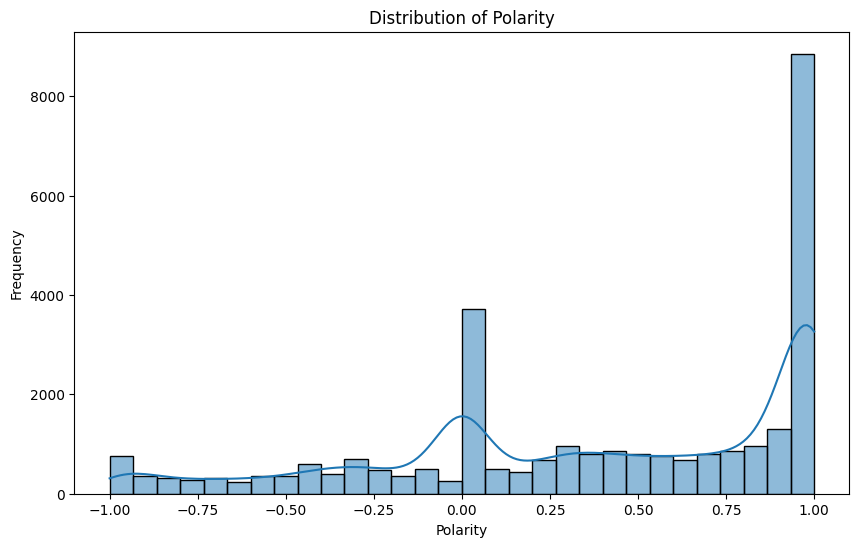

In [ ]:
sf['polarity'] = sf['sentiment'].apply(lambda x: x['polarity'] if x is not None else None)

daily_polarity = sf.groupby('date')['polarity'].median().reset_index()

plt.figure(figsize=(10, 6))
sns.histplot(sf['polarity'], bins=30, kde=True)
plt.title('Distribution of Polarity')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
daily_polarity['date'] = pd.to_datetime(daily_polarity['date']).dt.strftime('%Y-%m-%d 00:00:00+00:00')


In [ ]:
daily_polarity

,date,polarity
0,2018-11-30 00:00:00+00:00,0.994
1,2019-01-02 00:00:00+00:00,0.983
2,2019-01-19 00:00:00+00:00,0.318
3,2019-01-30 00:00:00+00:00,0.318
4,2019-02-04 00:00:00+00:00,0.939
...,...,...
1157,2023-10-27 00:00:00+00:00,0.767
1158,2023-10-28 00:00:00+00:00,0.077
1159,2023-10-29 00:00:00+00:00,0.395
1160,2023-10-30 00:00:00+00:00,0.492


In [ ]:
daily_polarity.value_counts()

,,count
date,polarity,
2018-11-30 00:00:00+00:00,0.994,1
2022-11-01 00:00:00+00:00,0.519,1
2022-10-12 00:00:00+00:00,0.340,1
2022-10-11 00:00:00+00:00,0.875,1
2022-10-10 00:00:00+00:00,0.000,1
...,...,...
2021-09-14 00:00:00+00:00,0.856,1
2021-09-13 00:00:00+00:00,0.648,1
2021-09-12 00:00:00+00:00,0.392,1


In [ ]:
daily_polarity.duplicated().sum()

0

In [ ]:
daily_polarity.set_index('date', inplace=True)


In [ ]:
daily_polarity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1162 entries, 2018-11-30 00:00:00+00:00 to 2023-10-31 00:00:00+00:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   polarity  1162 non-null   float64
dtypes: float64(1)
memory usage: 18.2+ KB


In [ ]:
daily_polarity = daily_polarity.groupby(daily_polarity.index).mean()
# grouping the data by index so we can have 1 entry for each day

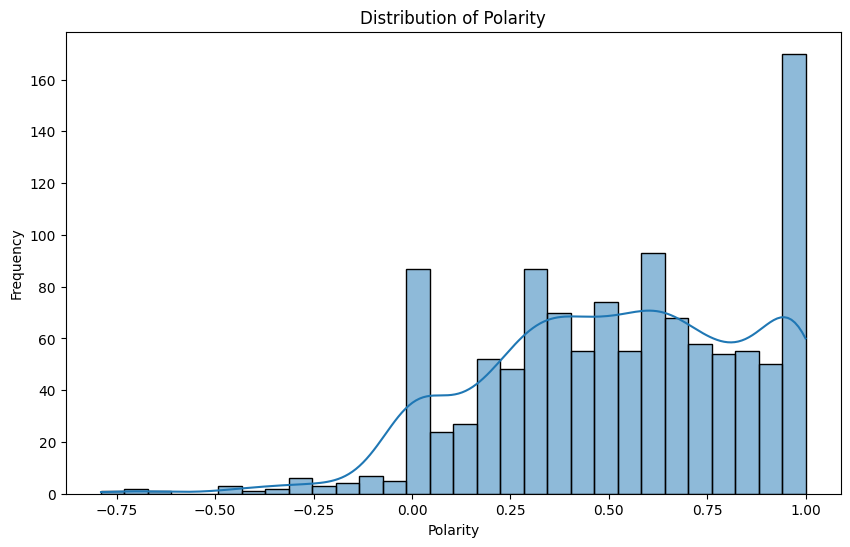

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(daily_polarity['polarity'], bins=30, kde=True)
plt.title('Distribution of Polarity')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
daily_polarity

,polarity
date,
2018-11-30 00:00:00+00:00,0.994
2019-01-02 00:00:00+00:00,0.983
2019-01-19 00:00:00+00:00,0.318
2019-01-30 00:00:00+00:00,0.318
2019-02-04 00:00:00+00:00,0.939
...,...
2023-10-27 00:00:00+00:00,0.767
2023-10-28 00:00:00+00:00,0.077
2023-10-29 00:00:00+00:00,0.395


In [ ]:
stock_data

,Tesla,Ford,Tesla_Log_Return,Ford_Log_Return,Tesla_MA_5,Tesla_MA_50,Tesla_Volatility
Date,,,,,,,
2019-01-14 00:00:00+00:00,22.293333,6.847369,-0.037736,0.019091,22.673466,22.764587,0.039266
2019-01-15 00:00:00+00:00,22.962000,6.733119,0.029553,-0.016826,22.794533,22.774067,0.040307
2019-01-16 00:00:00+00:00,23.070000,6.314203,0.004692,-0.064237,22.894800,22.776427,0.030873
2019-01-17 00:00:00+00:00,23.153999,6.367518,0.003634,0.008408,22.926000,22.777627,0.027206
2019-01-18 00:00:00+00:00,20.150667,6.535087,-0.138930,0.025976,22.326000,22.725440,0.052364
...,...,...,...,...,...,...,...
2023-10-24 00:00:00+00:00,216.520004,10.623935,0.020719,-0.007871,220.676001,248.037200,0.035287
2023-10-25 00:00:00+00:00,212.419998,10.763846,-0.019118,0.013084,214.624002,247.626400,0.034769
2023-10-26 00:00:00+00:00,205.759995,10.586627,-0.031855,-0.016601,211.754001,247.229599,0.034855


In [ ]:
daily_polarity.index = pd.to_datetime(daily_polarity.index)

stock_data['merge_date'] = stock_data.index.date

# Create a new date-only column in `daily_polarity`
daily_polarity['merge_date'] = daily_polarity.index.date

# Merge on the new `merge_date` column
merged_df = pd.merge(stock_data.reset_index(drop=True), daily_polarity.reset_index(drop=True), on='merge_date', how='left')

# Drop the temporary `merge_date` column if not needed afterward

# Display the merged DataFrame
print(merged_df.head())









       Tesla      Ford  Tesla_Log_Return  Ford_Log_Return  Tesla_MA_5  \
0  22.293333  6.847369         -0.037736         0.019091   22.673466   
1  22.962000  6.733119          0.029553        -0.016826   22.794533   
2  23.070000  6.314203          0.004692        -0.064237   22.894800   
3  23.153999  6.367518          0.003634         0.008408   22.926000   
4  20.150667  6.535087         -0.138930         0.025976   22.326000   

   Tesla_MA_50  Tesla_Volatility  merge_date  polarity  
0    22.764587          0.039266  2019-01-14       NaN  
1    22.774067          0.040307  2019-01-15       NaN  
2    22.776427          0.030873  2019-01-16       NaN  
3    22.777627          0.027206  2019-01-17       NaN  
4    22.725440          0.052364  2019-01-18       NaN  


In [ ]:
merged_df['polarity'].value_counts()

,count
polarity,
0.0000,40
0.3180,23
0.4220,13
0.2020,13
0.9970,13
...,...
0.1865,1
0.7810,1
0.6235,1


In [ ]:
stock_data['merge_date'].value_counts()

,count
merge_date,
2019-01-14,1
2022-04-01,1
2022-03-30,1
2022-03-29,1
2022-03-28,1
...,...
2020-08-18,1
2020-08-17,1
2020-08-14,1


In [ ]:
stock_dates = set(stock_data['merge_date'])
polarity_dates = set(daily_polarity['merge_date'])

# Find the intersection of both sets
common_dates = stock_dates.intersection(polarity_dates)

# Check if there are any common dates and print the result
if common_dates:
    print("Common dates found:", common_dates)
    print(f"Number of common dates: {len(common_dates)}")
else:
    print("No common dates found.")

Common dates found: {datetime.date(2022, 10, 3), datetime.date(2021, 12, 14), datetime.date(2023, 8, 29), datetime.date(2023, 10, 4), datetime.date(2021, 2, 18), datetime.date(2020, 9, 29), datetime.date(2022, 1, 28), datetime.date(2023, 1, 4), datetime.date(2022, 6, 8), datetime.date(2022, 4, 14), datetime.date(2022, 8, 17), datetime.date(2021, 6, 14), datetime.date(2023, 6, 30), datetime.date(2022, 12, 28), datetime.date(2020, 11, 2), datetime.date(2023, 8, 11), datetime.date(2022, 6, 28), datetime.date(2021, 10, 19), datetime.date(2022, 8, 3), datetime.date(2023, 7, 11), datetime.date(2021, 8, 18), datetime.date(2022, 3, 23), datetime.date(2022, 8, 4), datetime.date(2021, 3, 23), datetime.date(2023, 6, 6), datetime.date(2022, 8, 1), datetime.date(2021, 10, 12), datetime.date(2021, 12, 21), datetime.date(2021, 6, 7), datetime.date(2019, 2, 19), datetime.date(2021, 2, 17), datetime.date(2021, 7, 27), datetime.date(2019, 7, 24), datetime.date(2021, 6, 9), datetime.date(2023, 4, 13), da

In [ ]:
daily_polarity['merge_date'].value_counts()

,count
merge_date,
2018-11-30,1
2022-11-01,1
2022-10-12,1
2022-10-11,1
2022-10-10,1
...,...
2021-09-14,1
2021-09-13,1
2021-09-12,1


In [ ]:
merged_df.isna().sum()

,0
Tesla,0
Ford,0
Tesla_Log_Return,0
Ford_Log_Return,0
Tesla_MA_5,0
Tesla_MA_50,0
Tesla_Volatility,0
merge_date,0
polarity,368


In [ ]:
merged_df['polarity'].fillna(0, inplace=True)

<ipython-input-31-b6ce1af83b58>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['polarity'].fillna(0, inplace=True)


In [ ]:
merged_df['polarity'].value_counts()

,count
polarity,
0.0000,408
0.3180,23
0.4220,13
0.2020,13
0.9970,13
...,...
0.7810,1
0.6235,1
0.4580,1


In [ ]:
merged_df.reset_index()

,index,Tesla,Ford,Tesla_Log_Return,Ford_Log_Return,Tesla_MA_5,Tesla_MA_50,Tesla_Volatility,merge_date,polarity
0,0,22.293333,6.847369,-0.037736,0.019091,22.673466,22.764587,0.039266,2019-01-14,0.000
1,1,22.962000,6.733119,0.029553,-0.016826,22.794533,22.774067,0.040307,2019-01-15,0.000
2,2,23.070000,6.314203,0.004692,-0.064237,22.894800,22.776427,0.030873,2019-01-16,0.000
3,3,23.153999,6.367518,0.003634,0.008408,22.926000,22.777627,0.027206,2019-01-17,0.000
4,4,20.150667,6.535087,-0.138930,0.025976,22.326000,22.725440,0.052364,2019-01-18,0.000
...,...,...,...,...,...,...,...,...,...,...
1203,1203,216.520004,10.623935,0.020719,-0.007871,220.676001,248.037200,0.035287,2023-10-24,0.649
1204,1204,212.419998,10.763846,-0.019118,0.013084,214.624002,247.626400,0.034769,2023-10-25,0.860
1205,1205,205.759995,10.586627,-0.031855,-0.016601,211.754001,247.229599,0.034855,2023-10-26,0.691
1206,1206,207.300003,9.290114,0.007457,-0.130641,210.816000,246.991199,0.035994,2023-10-27,0.767


In [ ]:
merged_df.head(10)

,Tesla,Ford,Tesla_Log_Return,Ford_Log_Return,Tesla_MA_5,Tesla_MA_50,Tesla_Volatility,merge_date,polarity
0,22.293333,6.847369,-0.037736,0.019091,22.673466,22.764587,0.039266,2019-01-14,0.0
1,22.962000,6.733119,0.029553,-0.016826,22.794533,22.774067,0.040307,2019-01-15,0.0
2,23.070000,6.314203,0.004692,-0.064237,22.894800,22.776427,0.030873,2019-01-16,0.0
3,23.153999,6.367518,0.003634,0.008408,22.926000,22.777627,0.027206,2019-01-17,0.0
4,20.150667,6.535087,-0.138930,0.025976,22.326000,22.725440,0.052364,2019-01-18,0.0
5,19.927999,6.474153,-0.011112,-0.009368,21.852933,22.669253,0.048248,2019-01-22,0.0
6,19.172667,6.352287,-0.038640,-0.019003,21.095066,22.588493,0.048738,2019-01-23,0.0
7,19.434000,6.550321,0.013538,0.030699,20.367867,22.508640,0.048986,2019-01-24,0.0
8,19.802668,6.748352,0.018793,0.029784,19.697600,22.437347,0.048982,2019-01-25,0.0
9,19.758667,6.596020,-0.002224,-0.022832,19.619200,22.390813,0.048628,2019-01-28,0.0


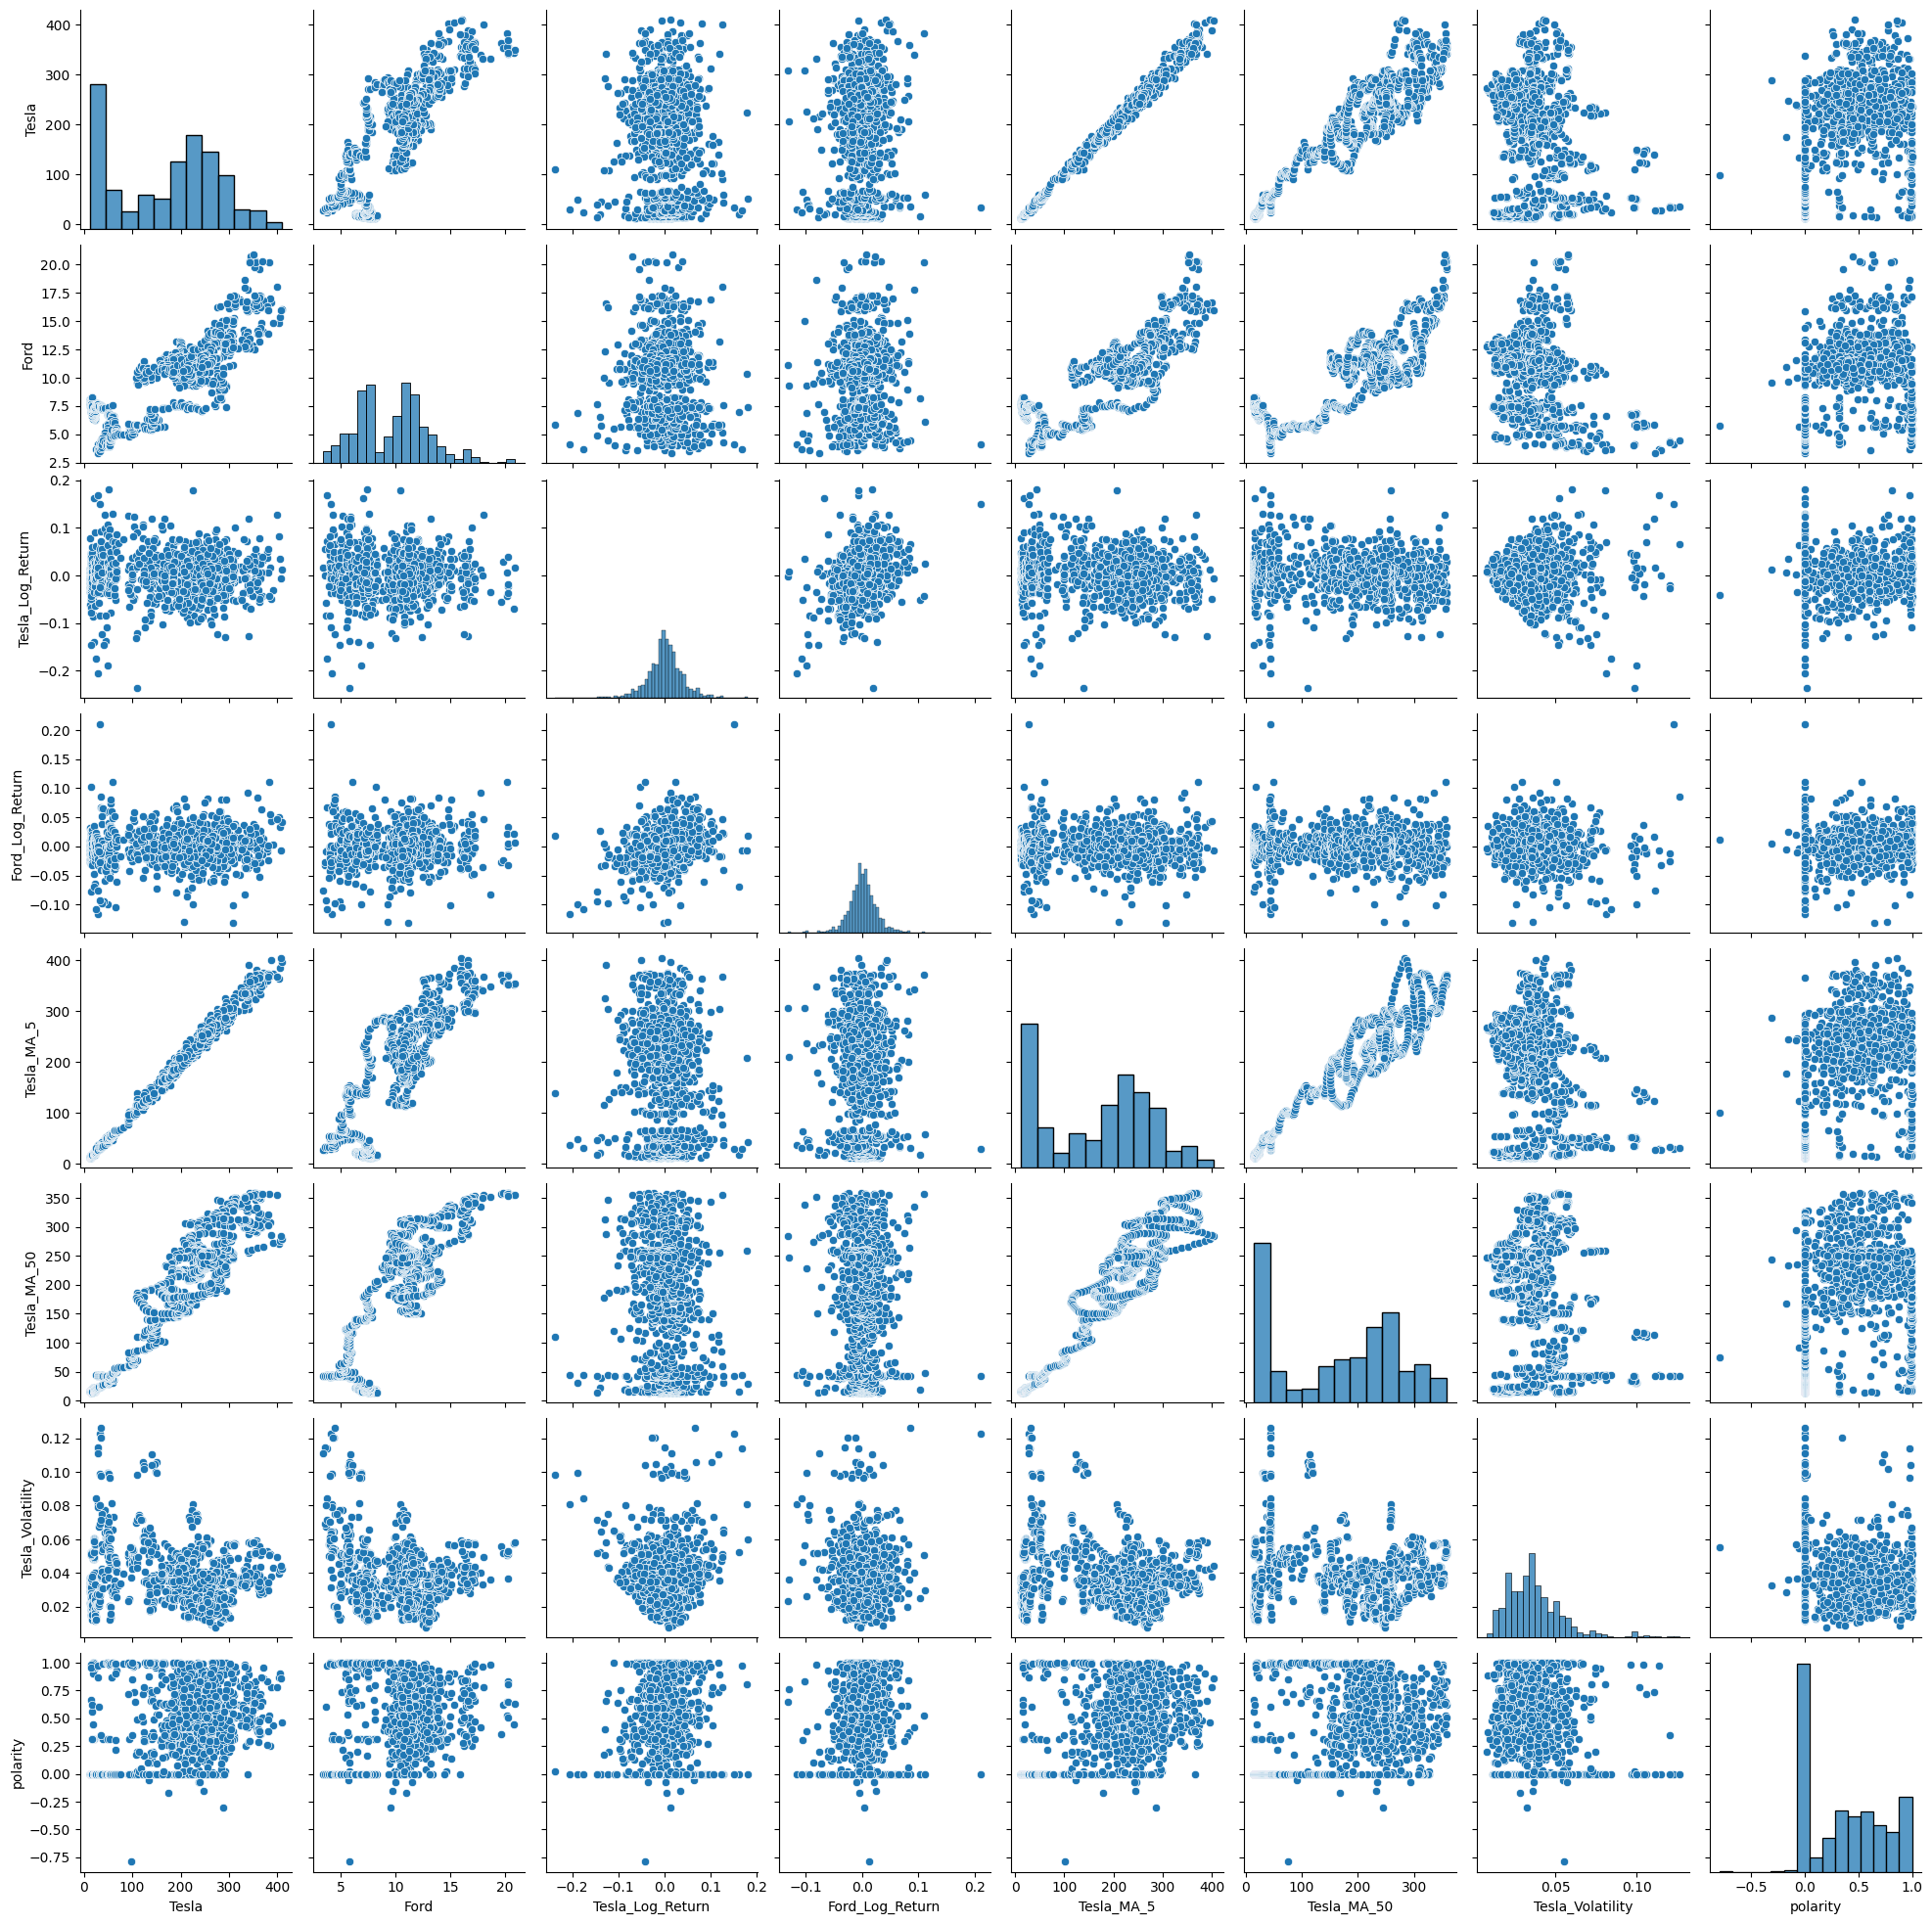

In [ ]:
# For Tesla
sns.pairplot(merged_df)
plt.show()

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Tesla             1208 non-null   float64
 1   Ford              1208 non-null   float64
 2   Tesla_Log_Return  1208 non-null   float64
 3   Ford_Log_Return   1208 non-null   float64
 4   Tesla_MA_5        1208 non-null   float64
 5   Tesla_MA_50       1208 non-null   float64
 6   Tesla_Volatility  1208 non-null   float64
 7   merge_date        1208 non-null   object 
 8   polarity          1208 non-null   float64
dtypes: float64(8), object(1)
memory usage: 85.1+ KB


In [ ]:
merged_df.sort_values(by='merge_date', inplace=True)

In [ ]:
merged_df['date'] = pd.to_datetime(merged_df['merge_date'])

In [ ]:
merged_df

,Tesla,Ford,Tesla_Log_Return,Ford_Log_Return,Tesla_MA_5,Tesla_MA_50,Tesla_Volatility,merge_date,polarity,date
0,22.293333,6.847369,-0.037736,0.019091,22.673466,22.764587,0.039266,2019-01-14,0.000,2019-01-14
1,22.962000,6.733119,0.029553,-0.016826,22.794533,22.774067,0.040307,2019-01-15,0.000,2019-01-15
2,23.070000,6.314203,0.004692,-0.064237,22.894800,22.776427,0.030873,2019-01-16,0.000,2019-01-16
3,23.153999,6.367518,0.003634,0.008408,22.926000,22.777627,0.027206,2019-01-17,0.000,2019-01-17
4,20.150667,6.535087,-0.138930,0.025976,22.326000,22.725440,0.052364,2019-01-18,0.000,2019-01-18
...,...,...,...,...,...,...,...,...,...,...
1203,216.520004,10.623935,0.020719,-0.007871,220.676001,248.037200,0.035287,2023-10-24,0.649,2023-10-24
1204,212.419998,10.763846,-0.019118,0.013084,214.624002,247.626400,0.034769,2023-10-25,0.860,2023-10-25
1205,205.759995,10.586627,-0.031855,-0.016601,211.754001,247.229599,0.034855,2023-10-26,0.691,2023-10-26
1206,207.300003,9.290114,0.007457,-0.130641,210.816000,246.991199,0.035994,2023-10-27,0.767,2023-10-27


In [ ]:
merged_df =merged_df.drop(columns=['merge_date'])

# model training

model training using LSTM


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the features (X) and target (y)
X = merged_df.drop(columns=['Tesla_Log_Return', 'date'])  # Exclude target and date column
y = merged_df['Tesla_Log_Return']  # Target variable

# Standardize the features for LSTM input
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize TimeSeriesSplit with the desired number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Iterate over each split
for fold, (train_index, test_index) in enumerate(tscv.split(X_scaled)):
    print(f"\nFold {fold + 1}")

    # Split the data into training and testing sets based on the indices
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Reshape data to fit LSTM input requirements (samples, time steps, features)
    X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # Build the LSTM model with dropout and regularization
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
    model.add(LSTM(50, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
    model.add(Dense(1))

    # Compile with a lower learning rate
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    # Train the model with smaller batch size and increased epochs for stability
    model.fit(X_train_reshaped, y_train, epochs=100, batch_size=16, verbose=0, validation_split=0.1)

    # Make predictions
    y_pred = model.predict(X_test_reshaped).flatten()

    # Evaluate the model with additional metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print("R^2 Score:", r2)

# Note: The mean of MSE, MAE, or R^2 across all folds can give you an overall performance metric.



Fold 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Mean Squared Error: 0.0024999256272468227
Mean Absolute Error: 0.03202168674789681
R^2 Score: 0.33682032856288135

Fold 2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Mean Squared Error: 0.0006544579393419011
Mean Absolute Error: 0.019399955827380324
R^2 Score: 0.5111713806005643

Fold 3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Mean Squared Error: 0.00046887776809172627
Mean Absolute Error: 0.016030791032115625
R^2 Score: 0.6298703174135216

Fold 4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Mean Squared Error: 0.0007403931112899224
Mean Absolute Error: 0.021118425488210482
R^2 Score: 0.595596815131177

Fold 5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Mean Squared Error: 0.0003916073110445554
Mean Absolute Error: 0.015189328227583407
R^2 Score: 0.6596472063942023


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

# Define the features (X) and target (y)
X = merged_df.drop(columns=['Tesla_Log_Return', 'date'])  # Exclude target and date column
y = merged_df['Tesla_Log_Return']  # Target variable

# Initialize TimeSeriesSplit with the desired number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Iterate over each split
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"\nFold {fold + 1}")

    # Split the data into training and testing sets based on the indices
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train a RandomForestRegressor for feature selection
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    # Feature importance from the Random Forest model
    importances = rf_model.feature_importances_

    # Select features based on importance
    selector = SelectFromModel(rf_model, threshold="mean", prefit=True)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    # Get selected feature names
    selected_features = X.columns[selector.get_support()]
    print("Selected features:", selected_features)

    # Train an XGBoost Regressor using the selected features
    from xgboost import XGBRegressor
    xgb_model = XGBRegressor(random_state=42)
    xgb_model.fit(X_train_selected, y_train)

    # Make predictions and evaluate the model
    y_pred = xgb_model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Mean Squared Error:", mse)
    print("R^2 Score:", r2)

# Note: The mean of MSE or R^2 across all folds can give you an overall performance metric.



Fold 1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected features: Index(['Ford_Log_Return'], dtype='object')
Mean Squared Error: 0.0029138127237119536
R^2 Score: 0.002234656623817055

Fold 2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected features: Index(['Ford_Log_Return', 'Tesla_Volatility'], dtype='object')
Mean Squared Error: 0.002659704931486427
R^2 Score: -0.3178453217039845

Fold 3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected features: Index(['Ford_Log_Return', 'Tesla_Volatility'], dtype='object')
Mean Squared Error: 0.0018741072400106622
R^2 Score: -0.6045053496223254

Fold 4


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected features: Index(['Ford_Log_Return', 'Tesla_Volatility'], dtype='object')
Mean Squared Error: 0.002031163697163964
R^2 Score: -0.13912132846185066

Fold 5
Selected features: Index(['Ford_Log_Return', 'Tesla_Volatility'], dtype='object')
Mean Squared Error: 0.001290863812216715
R^2 Score: -0.10333995949049579


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


# Adding technical indicators

In [ ]:
# Bollinger Bands using Tesla_MA_5
merged_df['Tesla_Bollinger_Upper_5'] = merged_df['Tesla_MA_5'] + 2 * merged_df['Tesla'].rolling(window=5).std()
merged_df['Tesla_Bollinger_Lower_5'] = merged_df['Tesla_MA_5'] - 2 * merged_df['Tesla'].rolling(window=5).std()

# Bollinger Bands using Tesla_MA_50
merged_df['Tesla_Bollinger_Upper_50'] = merged_df['Tesla_MA_50'] + 2 * merged_df['Tesla'].rolling(window=50).std()
merged_df['Tesla_Bollinger_Lower_50'] = merged_df['Tesla_MA_50'] - 2 * merged_df['Tesla'].rolling(window=50).std()

# RSI calculation (adjustable period, default is 14)
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

merged_df['Tesla_RSI_5'] = calculate_rsi(merged_df['Tesla'], period=5)  # RSI with a shorter period for higher sensitivity
merged_df['Tesla_RSI_50'] = calculate_rsi(merged_df['Tesla'], period=50)  # RSI with a longer period for broader trend

# MACD calculation (using default periods of 12 and 26)
merged_df['Tesla_MACD'] = merged_df['Tesla'].ewm(span=12, adjust=False).mean() - merged_df['Tesla'].ewm(span=26, adjust=False).mean()

# Lagged returns (1 day and 5 days)
merged_df['Tesla_Log_Return_Lag1'] = merged_df['Tesla_Log_Return'].shift(1)
merged_df['Tesla_Log_Return_Lag5'] = merged_df['Tesla_Log_Return'].shift(5)

# Drop rows with NaNs resulting from rolling calculations
merged_df.dropna(inplace=True)


In [ ]:
merged_df['Tesla_Direction'] = np.where(merged_df['Tesla_Log_Return'] > 0, 1, 0)

# Define the features (X) and target (y)
X = merged_df.drop(columns=['Tesla_Log_Return', 'Tesla_Direction', 'date'])  # Exclude original target and date column
y = merged_df['Tesla_Direction']  # Binary target for classification

# Initialize TimeSeriesSplit with the desired number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Iterate over each split
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"\nFold {fold + 1}")

    # Split the data into training and testing sets based on the indices
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train a RandomForestClassifier for feature selection
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    # Feature importance from the Random Forest model
    importances = rf_model.feature_importances_

    # Select features based on importance
    selector = SelectFromModel(rf_model, threshold="mean", prefit=True)
    X_train_selected = selector.transform(X_train.values)  # Use .values to avoid warnings
    X_test_selected = selector.transform(X_test.values)    # Use .values to avoid warnings

    # Get selected feature names
    selected_features = X.columns[selector.get_support()]
    print("Selected features:", selected_features)

    # Train an XGBoost Classifier using the selected features
    xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train_selected, y_train)

    # Make predictions and evaluate the model
    y_pred = xgb_model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_test, y_pred))


Fold 1
Selected features: Index(['Ford_Log_Return', 'Tesla_Volatility', 'Tesla_RSI_5',
       'Tesla_Log_Return_Lag1', 'Tesla_Log_Return_Lag5'],
      dtype='object')
Accuracy: 0.6424870466321243
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.66      0.61        82
           1       0.71      0.63      0.67       111

    accuracy                           0.64       193
   macro avg       0.64      0.64      0.64       193
weighted avg       0.65      0.64      0.64       193


Fold 2


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:40:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Selected features: Index(['Ford_Log_Return', 'Tesla_RSI_5', 'Tesla_RSI_50',
       'Tesla_Log_Return_Lag1', 'Tesla_Log_Return_Lag5'],
      dtype='object')
Accuracy: 0.5906735751295337
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.65      0.60        93
           1       0.62      0.54      0.58       100

    accuracy                           0.59       193
   macro avg       0.59      0.59      0.59       193
weighted avg       0.59      0.59      0.59       193


Fold 3


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:40:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Selected features: Index(['Ford_Log_Return', 'Tesla_RSI_5', 'Tesla_RSI_50',
       'Tesla_Log_Return_Lag1', 'Tesla_Log_Return_Lag5'],
      dtype='object')
Accuracy: 0.6528497409326425
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.56      0.58        84
           1       0.68      0.72      0.70       109

    accuracy                           0.65       193
   macro avg       0.65      0.64      0.64       193
weighted avg       0.65      0.65      0.65       193


Fold 4


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:41:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Selected features: Index(['Ford_Log_Return', 'Tesla_Volatility', 'Tesla_RSI_5', 'Tesla_RSI_50',
       'Tesla_Log_Return_Lag1', 'Tesla_Log_Return_Lag5'],
      dtype='object')
Accuracy: 0.7046632124352331
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.76      0.72        99
           1       0.72      0.65      0.68        94

    accuracy                           0.70       193
   macro avg       0.71      0.70      0.70       193
weighted avg       0.71      0.70      0.70       193


Fold 5


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:41:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Selected features: Index(['Ford_Log_Return', 'Tesla_RSI_5', 'Tesla_RSI_50',
       'Tesla_Log_Return_Lag1'],
      dtype='object')
Accuracy: 0.6787564766839378
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.66        91
           1       0.70      0.69      0.69       102

    accuracy                           0.68       193
   macro avg       0.68      0.68      0.68       193
weighted avg       0.68      0.68      0.68       193



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:41:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
file_path = '/content/drive/MyDrive/KaggleDatasets/final_df.csv'

# Save the DataFrame as a CSV file
merged_df.to_csv(file_path, index=False)

print(f"File saved to {file_path}")

OSError: Cannot save file into a non-existent directory: '/content/drive/MyDrive/KaggleDatasets'